In [1]:
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

import GPy
from GPy import kern as kern

import emupints
import emupints.plot as emuplt
import emupints.utils as emutils
import emupints.metrics as emumet

from sklearn.preprocessing import StandardScaler

## Problem creation

In [2]:
# Load problem from predefined ones
model = emupints.Problems.SIRModel
problem = emupints.Problems.load_problem(model)

problem['values'][:5]

array([[ 1.49876089, -1.37566955],
       [ 1.9449817 ,  3.17878563],
       [ 2.36792636, -2.51406529],
       [ 1.22616989,  1.99563624],
       [ 1.40802103, -2.12700592]])

In [3]:
# take required variables for visualisation
n_parameters = problem['n_parameters']
log_likelihood = problem['log_likelihood']
bounds = problem['bounds']
index_to_param_name = problem['param_names']

## Timing prediction time vs number of training points

In [6]:
# Model : Time to execute vs number of times (expect to be close to linear?)
# Emulator : Time to execute vs number of training points 
import time

import warnings
warnings.filterwarnings('ignore')

In [29]:
# Create data to test
train_sizes = [100 * i for i in range(1, 40, 2)]
training_set = bounds.sample(train_sizes[-1])
target_likelihoods = np.apply_along_axis(log_likelihood, 1, training_set)

# Example kernels in use
kernels = [
    (kern.MLP(n_parameters), 'MLP'),
    (kern.RBF(n_parameters), 'RBF'),
    (kern.Matern52(n_parameters), 'Matern'),
    (kern.RatQuad(n_parameters), 'RatQuad'), 
]

# Store results for each kernel in these dicts
kern_train_times = {}
kern_prediction_times = {}

for kernel, kernel_name in kernels:
    print("Kernel: " + kernel_name)

    # store result for each kernel
    emu_train_times = []
    emu_prediction_times = []
    for size in train_sizes:
        test_inputs = training_set[:size]
        test_outputs = target_likelihoods[:size]
                
        def train_gp():
            test_emu = emupints.GPEmulator(log_likelihood, test_inputs, test_outputs, 
                                           input_scaler=StandardScaler())
            test_emu.set_parameters(kernel = kernel)
            test_emu.fit(normalizer = True, messages = False)
            
            return test_emu

        train_time = %timeit -o -q train_gp()
        train_time = train_time.average
        emu_train_times.append(train_time)
        
        # Initialize GP and performd predictions
        test_emu = train_gp()
        
        pred_time = %timeit -o -q test_emu(bounds.sample(1)[0])
        pred_time = pred_time.average
        emu_prediction_times.append(pred_time)

        print("    Size {}: {:.5f}, {:.5f}".format(size, emu_train_times[-1], emu_prediction_times[-1]))

    kern_train_times[kernel_name] = emu_train_times[::]
    kern_prediction_times[kernel_name] = emu_prediction_times[::]    

Kernel: MLP
    Size 100: 0.05580, 0.00039
    Size 300: 0.27821, 0.00067
    Size 500: 0.53724, 0.00072
    Size 700: 1.28855, 0.00071
    Size 900: 2.81087, 0.00091
    Size 1100: 4.18714, 0.00080
    Size 1300: 5.84737, 0.00108
    Size 1500: 9.77217, 0.00156
    Size 1700: 10.11452, 0.00189
    Size 1900: 14.42708, 0.00304
    Size 2100: 28.09059, 0.00324
    Size 2300: 19.57920, 0.00295
    Size 2500: 28.91699, 0.00388
    Size 2700: 28.22916, 0.00425
    Size 2900: 36.38405, 0.00563
    Size 3100: 53.11646, 0.00550
    Size 3300: 45.67552, 0.00613
    Size 3500: 72.22583, 0.00707
    Size 3700: 78.12565, 0.00845
    Size 3900: 75.59896, 0.00885
Kernel: RBF
    Size 100: 0.03700, 0.00033
    Size 300: 0.11949, 0.00042
    Size 500: 0.49586, 0.00045
    Size 700: 1.14124, 0.00052
    Size 900: 1.56600, 0.00063
    Size 1100: 2.59613, 0.00091
    Size 1300: 3.92654, 0.00130
    Size 1500: 6.04306, 0.00175
    Size 1700: 7.99468, 0.00211
    Size 1900: 11.33216, 0.00257
    Size 2100

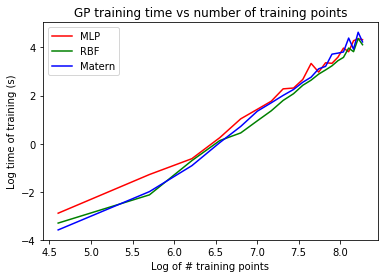

In [30]:
mlp_train_times = kern_train_times['MLP']
rbf_train_times = kern_train_times['RBF']
matern_train_times = kern_train_times['Matern']

# want log-log scale
log_train_sizes = np.log(train_sizes)
log_mlp_train_times = np.log(mlp_train_times)
log_rbf_train_times = np.log(rbf_train_times)
log_matern_train_times = np.log(matern_train_times)

plt.plot(log_train_sizes, log_mlp_train_times, label='MLP', color='r')
plt.plot(log_train_sizes, log_rbf_train_times, label='RBF', color='g')
plt.plot(log_train_sizes, log_matern_train_times, label='Matern', color='b')
plt.title("GP training time vs number of training points")
plt.xlabel("Log of # training points")
plt.ylabel("Log time of training (s)")
plt.legend()
plt.show()

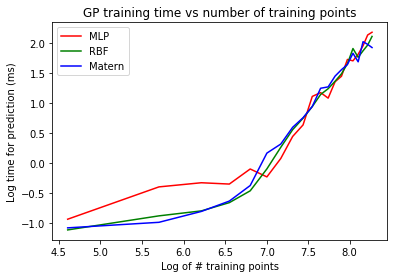

In [32]:
# convert to millimeters
mlp_prediction_times = np.array(kern_prediction_times['MLP']) * 1000
rbf_prediction_times = np.array(kern_prediction_times['RBF']) * 1000
matern_prediction_times = np.array(kern_prediction_times['Matern']) * 1000

# want log-log scale
log_train_sizes = np.log(train_sizes)
log_mlp_prediction_times = np.log(mlp_prediction_times)
log_rbf_prediction_times = np.log(rbf_prediction_times)
log_matern_prediction_times = np.log(matern_prediction_times)

plt.plot(log_train_sizes, log_mlp_prediction_times, label='MLP', color='r')
plt.plot(log_train_sizes, log_rbf_prediction_times, label='RBF', color='g')
plt.plot(log_train_sizes, log_matern_prediction_times, label='Matern', color='b')
plt.title("GP training time vs number of training points")
plt.xlabel("Log of # training points")
plt.ylabel("Log time for prediction (ms)")
plt.legend()
plt.show()

## Prediction time and mae depending on Kernel and problem

In [3]:
kernel_names = [
    'RBF',
    'RatQuad',
    'MLP',
    'Matern',
    'RatQuad + RBF',
    'MLP + RBF',
    'Matern + RBF',
    'MLP + Matern + RatQuad'
]

In [4]:
train_size = 1000
test_size = 400
optimizer = "lbfgs"

problems = [
    (emupints.Problems.LogisticModel, 'Logistic'),
    (emupints.Problems.SIRModel, 'SIR'),
    (emupints.Problems.FitzhughNagumoModel, 'FitzhughNagumo'),
    (emupints.Problems.LotkaVolterraModel, 'LotkaVolterra'),
    (emupints.Problems.HodgkinHuxleyIKModel, 'HodgkinHuxleyIK'),
    (emupints.Problems.GoodwinOscillatorModel, 'GoodwinOscillator')
]

results = {}

for problem, problem_name in problems:
    print(problem_name)
    # load problem
    problem = emupints.Problems.load_problem(problem)
    n_parameters = problem['n_parameters']
    parameters = problem['parameters']
    log_likelihood = problem['log_likelihood']
    log_posterior = problem['log_posterior']
    bounds = problem['bounds']
    
    # create data for training and testing
    train_X = parameters + np.random.randn(train_size, n_parameters) * (0.05 * parameters)
    train_y = np.apply_along_axis(log_likelihood, 1, train_X)

    test_X = parameters + np.random.randn(test_size, n_parameters) * (0.05 * parameters)
    test_y = np.apply_along_axis(log_likelihood, 1, test_X)

    # create appropriate kernels
    kernels = [
        kern.RBF(n_parameters),
        kern.RatQuad(n_parameters),
        kern.MLP(n_parameters),
        kern.Matern52(n_parameters),
        kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
        kern.Matern52(n_parameters) + kern.RBF(n_parameters),
        kern.RatQuad(n_parameters) + kern.RBF(n_parameters),
        kern.MLP(n_parameters) + kern.Matern52(n_parameters) + kern.RatQuad(n_parameters),
    ]
    
    # metrics to store
    kernel_chain_mae = []
    kernel_chain_mape = []
    kernel_time = []
    
    for kernel, kernel_name in zip(kernels, kernel_names):
        # train emulator
        emu = emupints.GPEmulator(log_likelihood, train_X, train_y,
                                  input_scaler=StandardScaler())
        emu.set_parameters(kernel = kernel)
        emu.fit(optimize = False, normalizer = True)
        emu.optimize(messages = False)

        # Perform single MCMC run to calcluate chain mape
        mcmc = pints.MCMCSampling(
            log_posterior, 
            1, # one chain
            [parameters], 
        )
        mcmc.set_max_iterations(10000)
        mcmc.set_log_to_screen(False)
        mcmc_chain = mcmc.run()[0]
    
        # accuracy via mae
        chain_mae = emumet.chain_mae(mcmc_chain, emu, log_likelihood)
        kernel_chain_mae.append(chain_mae)
        
        # accuracy via absolute error along a chain 
        chain_mape = emumet.chain_mape(mcmc_chain, emu, log_likelihood)
        kernel_chain_mape.append(chain_mape)

        # speed
        pred_time = %timeit -o -q emu(parameters)
        pred_time = pred_time.average
        kernel_time.append(pred_time)
        
        # delete used emulators
        del emu
        
        print("    {}: {:.5f}, {:.5f}, {:.10f}".format(kernel_name, chain_mae, chain_mape, pred_time))
    
    # store results
    results[problem_name] = [kernel_chain_mae, kernel_chain_mape, kernel_time]

Logistic
    RBF: 0.00061, 0.00000, 0.0007818337
    RatQuad: 0.00053, 0.00000, 0.0007505175
    MLP: 0.00020, 0.00000, 0.0010833383
    Matern: 0.00045, 0.00000, 0.0007484719
    RatQuad + RBF: 0.00048, 0.00000, 0.0010253947
    MLP + RBF: 0.00059, 0.00000, 0.0011168599
    Matern + RBF: 0.00048, 0.00000, 0.0008765139
    MLP + Matern + RatQuad: 0.00061, 0.00000, 0.0012334419
SIR
    RBF: 7.57006, 0.01242, 0.0005577706


 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:688: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:690: RuntimeWarning:invalid value encountered in multiply


    RatQuad: 5.60710, 0.00921, 0.0007726966
    MLP: 8.51393, 0.01396, 0.0007341628
    Matern: 10.41498, 0.01703, 0.0008778331
    RatQuad + RBF: 8.09238, 0.01326, 0.0012562147
    MLP + RBF: 7.98399, 0.01309, 0.0009138635
    Matern + RBF: 7.49148, 0.01230, 0.0008571069
    MLP + Matern + RatQuad: 7.69806, 0.01262, 0.0012049140
FitzhughNagumo
    RBF: 0.47163, 0.00221, 0.0005645393
    RatQuad: 0.75134, 0.00383, 0.0006347588
    MLP: 0.76609, 0.00400, 0.0006680999
    Matern: 0.42709, 0.00197, 0.0007091200
    RatQuad + RBF: 0.73926, 0.00385, 0.0009566268
    MLP + RBF: 0.13075, 0.00057, 0.0009672187
    Matern + RBF: 0.67003, 0.00337, 0.0010715848
    MLP + Matern + RatQuad: 0.14196, 0.00062, 0.0012038039
LotkaVolterra
    RBF: 0.00766, 0.00001, 0.0005894633
    RatQuad: 0.00821, 0.00002, 0.0006091743
    MLP: 0.02187, 0.00004, 0.0007726229
    Matern: 0.03251, 0.00006, 0.0006405247
    RatQuad + RBF: 0.00792, 0.00002, 0.0009190934
    MLP + RBF: 0.00790, 0.00002, 0.0011025057
    M

 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:688: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:690: RuntimeWarning:invalid value encountered in multiply


    RatQuad + RBF: 0.10868, 0.00004, 0.0014658470
    MLP + RBF: 0.06794, 0.00003, 0.0008756992


 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:676: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:681: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:688: RuntimeWarning:overflow encountered in square
 /Users/maksympetyak/Prog/emupints/env/lib/python3.6/site-packages/GPy/kern/src/stationary.py:690: RuntimeWarning:invalid value encountered in multiply


    Matern + RBF: 0.10714, 0.00004, 0.0011945916
    MLP + Matern + RatQuad: 0.09679, 0.00004, 0.0014593109


In [18]:
# print results in a table format
# convenient print to copy paste result to Latex
problem_names = ['Logistic', 'SIR', 'FitzhughNagumo', 'LotkaVolterra', 'HodgkinHuxleyIK', 'GoodwinOscillator']
print(" " * 6, " ".join([n.center(10) for n in kernel_names[:-1]]))

for problem_name in problem_names:
    print(problem_name)
    problem_results = results[problem_name]
    mae, cmape, times = problem_results
    # discard last kernel
    mae, cmape, times = mae[:-1], cmape[:-1], times[:-1]
    
    # print mae
    print(" mae | & ", end="")
    print(" & ".join(["{:.5f}".format(x) for x in mae]))
    
    # print cmape
    print("cmape| & ".center(6), end="")
    print(" & ".join(["{:.5f}".format(x * 100)for x in cmape]))
    
    # print times
    print("time | & ".center(6), end="")
    print(" & ".join(["{:.2f}".format(x * 1000000)for x in times]))
    

          RBF      RatQuad      MLP       Matern   RatQuad + RBF MLP + RBF  Matern + RBF
Logistic
 mae | & 0.00061 & 0.00053 & 0.00020 & 0.00045 & 0.00048 & 0.00059 & 0.00048
cmape| & 0.00007 & 0.00006 & 0.00002 & 0.00005 & 0.00005 & 0.00006 & 0.00005
time | & 781.83 & 750.52 & 1083.34 & 748.47 & 1025.39 & 1116.86 & 876.51
SIR
 mae | & 7.57006 & 5.60710 & 8.51393 & 10.41498 & 8.09238 & 7.98399 & 7.49148
cmape| & 1.24211 & 0.92121 & 1.39595 & 1.70347 & 1.32636 & 1.30931 & 1.22992
time | & 557.77 & 772.70 & 734.16 & 877.83 & 1256.21 & 913.86 & 857.11
FitzhughNagumo
 mae | & 0.47163 & 0.75134 & 0.76609 & 0.42709 & 0.73926 & 0.13075 & 0.67003
cmape| & 0.22056 & 0.38326 & 0.39965 & 0.19665 & 0.38524 & 0.05661 & 0.33689
time | & 564.54 & 634.76 & 668.10 & 709.12 & 956.63 & 967.22 & 1071.58
LotkaVolterra
 mae | & 0.00766 & 0.00821 & 0.02187 & 0.03251 & 0.00792 & 0.00790 & 0.00773
cmape| & 0.00146 & 0.00156 & 0.00416 & 0.00619 & 0.00151 & 0.00150 & 0.00147
time | & 589.46 & 609.17 & 772.62 & 6